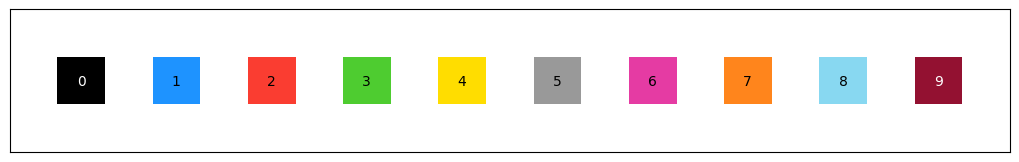

In [1]:
import sys
import json
import shutil
sys.path.append("../inputs/google-code-golf-2025/code_golf_utils")
from code_golf_utils import *
show_legend()

In [2]:
def get_examples(task_num):
    examples = load_examples(task_num)
    show_examples(examples['train'] + examples['test'])
    return examples

def save_file(task_num, sub_dir="/kaggle/working/submission/"):
    task_path = os.path.join(sub_dir, f"task{task_num:03d}.py")
    os.makedirs(sub_dir, exist_ok=True)
    shutil.copy("task.py", task_path)
    
def show_grid(out_grid, in_grid, ans_grid, figsize=(12, 4), k=-0.11):
    # Colors for each index
    colors = [
        (0, 0, 0),
        (30, 147, 255),
        (250, 61, 49),
        (78, 204, 48),
        (255, 221, 0),
        (153, 153, 153),
        (229, 59, 163),
        (255, 133, 28),
        (136, 216, 241),
        (147, 17, 49),
    ]
    colors = [(r/255, g/255, b/255) for r, g, b in colors]

    def plot_ax(ax, arr):
        rows = len(arr)
        cols = len(arr[0])
        # Draw each cell
        for y in range(rows):
            for x in range(cols):
                color = colors[arr[y][x]]
                rect = plt.Rectangle((x, y), 1, 1, facecolor=color, edgecolor="white")
                ax.add_patch(rect)

        # Axis limits
        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        # Center ticks in each cell
        ax.set_xticks([i + 0.5 for i in range(cols)])
        ax.set_yticks([i + 0.5 for i in range(rows)])
        # Label ticks as integers
        ax.set_xticklabels(range(cols))
        ax.set_yticklabels(range(rows))
        ax.tick_params(axis='both', length=0)
        # Move x-axis labels to top
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        # Invert y-axis so 0 is at the top
        ax.invert_yaxis()
        # Square cells
        ax.set_aspect('equal')

    fig, ax = plt.subplots(1, 3, figsize=figsize)
    plot_ax(ax[0],out_grid)
    ax[0].set_title("Output",y=k)
    plot_ax(ax[1], in_grid)
    ax[1].set_title("Input",y=k)
    plot_ax(ax[2],ans_grid)
    ax[2].set_title("Answer",y=k)
    plt.show()

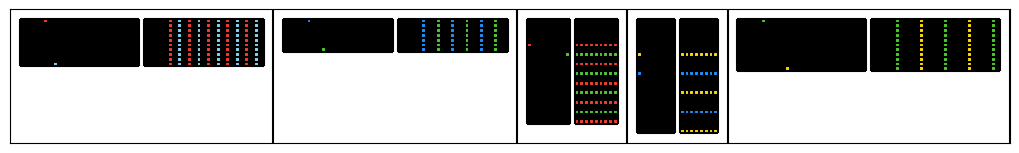

In [3]:
task_num = 13
examples = get_examples(task_num)

In [8]:
def p(grid):
    """
    ARC-AGI パターン変換関数
    
    ルール:
    - 横長グリッド + non-zeroが上下端 → 列パターンを右に繰り返し
    - 縦長グリッド + non-zeroが左右端 → 行パターンを下に繰り返し
    """
    import copy
    
    # グリッドをコピーして変更
    result = copy.deepcopy(grid)
    
    # グリッドの寸法
    height = len(grid)
    width = len(grid[0])
    
    # 非ゼロの値とその位置を見つける
    non_zero_positions = []
    non_zero_values = []
    
    for row_idx, row in enumerate(grid):
        for col_idx, value in enumerate(row):
            if value != 0:
                non_zero_positions.append((row_idx, col_idx))
                non_zero_values.append(value)
    
    # 非ゼロの値が2つない場合は元のグリッドを返す
    if len(non_zero_positions) != 2:
        return result
    
    pos1, pos2 = non_zero_positions
    val1, val2 = non_zero_values
    
    row1, col1 = pos1
    row2, col2 = pos2
    
    # 横長グリッドの場合（width > height）
    if width > height:
        # non-zeroが上下端にある場合（列パターンを右に繰り返し）
        if row1 != row2 and col1 == col2:
            # 上下の行を特定
            if row1 < row2:
                top_row, top_val = row1, val1
                bottom_row, bottom_val = row2, val2
            else:
                top_row, top_val = row2, val2
                bottom_row, bottom_val = row1, val1
            
            # パターンの間隔を計算
            pattern_height = bottom_row - top_row
            
            # 各列について、上下のパターンを右に繰り返し
            for c in range(width):
                for r in range(height):
                    relative_pos = (r - top_row) % (pattern_height * 2)
                    
                    if relative_pos == 0:
                        result[r][c] = top_val
                    elif relative_pos == pattern_height:
                        result[r][c] = bottom_val
    
    # 縦長グリッドの場合（height > width）
    elif height > width:
        # non-zeroが左右端にある場合（行パターンを下に繰り返し）
        if col1 != col2 and row1 == row2:
            # 左右の列を特定
            if col1 < col2:
                left_col, left_val = col1, val1
                right_col, right_val = col2, val2
            else:
                left_col, left_val = col2, val2
                right_col, right_val = col1, val1
            
            # パターンの間隔を計算
            pattern_width = right_col - left_col
            
            # 各行について、左右のパターンを下に繰り返し
            for r in range(height):
                for c in range(width):
                    relative_pos = (c - left_col) % (pattern_width * 2)
                    
                    if relative_pos == 0:
                        result[r][c] = left_val
                    elif relative_pos == pattern_width:
                        result[r][c] = right_val
    
    # 正方形または同じ行/列にある場合の従来のロジック
    else:
        # 同じ行にある場合（列を交互に埋める）
        if row1 == row2:
            # 列の順序を確定
            min_col = min(col1, col2)
            max_col = max(col1, col2)
            
            # どちらの値がどちらの列かを確定
            if col1 < col2:
                first_val, second_val = val1, val2
            else:
                first_val, second_val = val2, val1
            
            # 列の間隔を計算
            col_interval = max_col - min_col
            
            # 全ての行について列を埋める
            for r in range(len(result)):
                for c in range(len(result[r])):
                    # 基準位置からの相対位置を計算
                    relative_pos = (c - min_col) % (col_interval * 2)
                    
                    if relative_pos == 0:
                        result[r][c] = first_val
                    elif relative_pos == col_interval:
                        result[r][c] = second_val
        
        # 同じ列にある場合（行を交互に埋める）
        elif col1 == col2:
            # 行の順序を確定
            min_row = min(row1, row2)
            max_row = max(row1, row2)
            
            # どちらの値がどちらの行かを確定
            if row1 < row2:
                first_val, second_val = val1, val2
            else:
                first_val, second_val = val2, val1
            
            # 行の間隔を計算
            row_interval = max_row - min_row
            
            # 全ての列について行を埋める
            for r in range(len(result)):
                # 基準位置からの相対位置を計算
                relative_pos = (r - min_row) % (row_interval * 2)
                
                if relative_pos == 0:
                    for c in range(len(result[r])):
                        result[r][c] = first_val
                elif relative_pos == row_interval:
                    for c in range(len(result[r])):
                        result[r][c] = second_val
    
    return result

In [9]:
with open("../inputs/google-code-golf-2025/task013.json", "r", encoding="utf-8") as f:
  task_data = json.load(f)

example = task_data["train"][0]
input_grid = example["input"]
expected_output = example["output"]
actual_output = p(input_grid)

is_correct = actual_output == expected_output
status = "✓ 成功" if is_correct else "✗ 失敗"

print(input_grid)
print(expected_output)
print(actual_output)
print(status)

[[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 2, 0, 8, 0, 2, 0, 8, 0, 2, 0, 8, 0, 2, 0, 8, 0, 2, 0, 8, 0], [0, 0, 0, 0, 0, 2, 0, 8, 0, 2, 0, 8, 0, 2, 0, 8, 0, 2, 0, 8, 0, 2, 0, 8, 0], [0, 0, 0, 0, 0, 2, 0, 8, 0, 2, 0, 8, 0, 2, 0, 8, 0, 2, 0, 8, 0, 2, 0, 8, 0

In [ ]:
def test_json():
  with open("../inputs/google-code-golf-2025/task012.json", "r", encoding="utf-8") as f:
    task_data = json.load(f)
  
  train_success = 0
  for i, example in enumerate(task_data["train"]):
      input_grid = example["input"]
      expected_output = example["output"]
      actual_output = p(input_grid)
      
      is_correct = actual_output == expected_output
      status = "✓ 成功" if is_correct else "✗ 失敗"
      
      print(f"Train例{i+1}: {status}")
      if is_correct:
          train_success += 1

  print(f"訓練データの成功率: {train_success}/{len(task_data['train'])}")

  test_success = 0
  for i, example in enumerate(task_data["test"]):
      input_grid = example["input"]
      expected_output = example["output"]
      actual_output = p(input_grid)
      
      is_correct = actual_output == expected_output
      status = "✓ 成功" if is_correct else "✗ 失敗"
      
      print(f"Test例{i+1}: {status}")
      if is_correct:
          test_success += 1

  print(f"テストデータの成功率: {test_success}/{len(task_data['test'])}")

In [ ]:
test_json()